<a href="https://colab.research.google.com/github/geoskimoto/Roaring-Springs-GRCA-Precipitation-Response-Analysis/blob/master/SWE_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import functools as ft
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt 
from pathlib import Path
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from _plotly_future_ import v4_subplots
import plotly as pl
#import cufflinks as cf
#init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly import __version__
print(__version__)

4.4.1


In [ ]:
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
root_pat= '/content/drive/My Drive/Colab Notebooks/RS_TracerStudy'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


### Import Snow Data (Data recorded on Kaibab Plateau)

In [ ]:
#Bright Angel Weather Station
BA_Station = pd.read_csv('/content/drive/My Drive/Colab Notebooks/RS_TracerStudy/KP_weather_datafiles/BA_StationData.csv', index_col='DATE', parse_dates=True)
KP_SWE = pd.read_csv('/content/drive/My Drive/Colab Notebooks/RS_TracerStudy/KP_weather_datafiles/KP_SWE.csv',index_col='Date')
KP_discrete_snow_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/RS_TracerStudy/KP_weather_datafiles/KP_discrete_snow_data.xlsx')

In [ ]:
KP_discrete_snow_data.head(3)

,Date,Bright Angel (12N01),Bright Angel (12N01).1,Bright Angel (12N01).2,Bright Angel (12N01).3
0,NaN,Snow,Snow,Snow,Snow
1,NaN,Water,Depth,Water,Density
2,NaN,Equivalent,(in),Equivalent,(pct)


In [ ]:
KP_discrete_snow_data.drop([0,1,2,3,4], inplace=True)

In [ ]:
KP_discrete_snow_data.rename(columns={'Date':'Date half months','Bright Angel (12N01)': 'Date', 'Bright Angel (12N01).1': 'Snow Depth (in)', 'Bright Angel (12N01).2': 'SWE (in)', 'Bright Angel (12N01).3':'Snow Density (percent)'}, inplace=True)

In [ ]:
KP_discrete_snow_data.drop(['Date half months','Snow Density (percent)'], axis=1, inplace=True)

In [ ]:
KP_discrete_snow_data.head(3)

,Date,Snow Depth (in),SWE (in)
5,1947-02-23 00:00:00,26,7.1
6,1947-03-01 00:00:00,26,7.8
7,1947-03-15 00:00:00,25,7.6


In [ ]:
# year = KP_discrete_snow_data.iloc[:,0].str[13:]

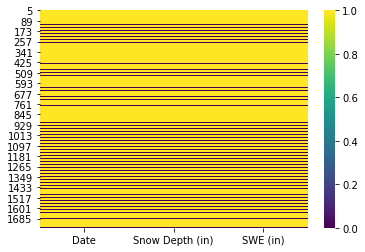

In [ ]:
sns.heatmap(KP_discrete_snow_data.isnull(), cmap='viridis')

In [ ]:
KP_discrete_snow_data.dropna(inplace=True)

In [ ]:
KP_discrete_snow_data.set_index('Date',inplace=True)

In [ ]:
# BA_Station.head(1)

,STATION,NAME,DAPR,MDPR,MDSF,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT04,WT05,WT06,WT11
DATE,,,,,,,,,,,,,,,,,
2010-01-01,USC00021001,"BRIGHT ANGEL RANGER STATION, AZ US",NaN,NaN,NaN,0.0,0.0,41.0,26.0,1.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
snow = pd.merge(BA_Station['SNWD'],KP_discrete_snow_data['SWE (in)'], left_index=True, right_index=True, how='outer')

In [ ]:
snow2 = pd.merge(snow, KP_discrete_snow_data['Snow Depth (in)'],left_index=True, right_index=True, how='outer')

In [ ]:
# sns.heatmap(snow.isnull(), cmap='viridis')

In [ ]:
# snow.reset_index()
# fig = px.scatter(snow, x=snow.index, y='Snow Water Equivalent (in) Start of Month Values')
# fig.show()
fig = go.Figure()
fig.add_trace(go.Scatter(x=KP_discrete_snow_data.index, y=KP_discrete_snow_data['SWE (in)']*2.54, mode='markers', name='SWE (cm)'))
fig.add_trace(go.Scatter(x=KP_discrete_snow_data.index,y=KP_discrete_snow_data['Snow Depth (in)']*2.54, mode='markers', name='Snow Depth (cm) taken at NRCS snow course'))
fig.add_trace(go.Scatter(x=BA_Station.index,y=BA_Station['SNWD'], name='Snow Depth at BA Station (mm)'))
# fig.add_trace(go.Scatter(x=BA_Station.index,y=BA_Station['PRCP'], name='Precipitation at BA Station (cm)'))


fig.update_layout(title='Snow Depth and SWE, Kaibab Plateau, AZ', yaxis_zeroline=False, xaxis_zeroline=False)

fig.show()

In [ ]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")


In [ ]:
adf_test(BA_Station['SNWD'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.943709e+00
p-value                 1.009754e-09
# lags used             2.900000e+01
# observations          3.545000e+03
critical value (1%)    -3.432196e+00
critical value (5%)    -2.862356e+00
critical value (10%)   -2.567204e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
adf_test(KP_discrete_snow_data['SWE (in)'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.024021e+00
p-value                 2.040133e-12
# lags used             1.000000e+00
# observations          3.990000e+02
critical value (1%)    -3.446846e+00
critical value (5%)    -2.868811e+00
critical value (10%)   -2.570643e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
